# Imports

In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wrangle import prep, acquire_zillow

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

import warnings
warnings.filterwarnings("ignore")



Number of observations removed: 10899


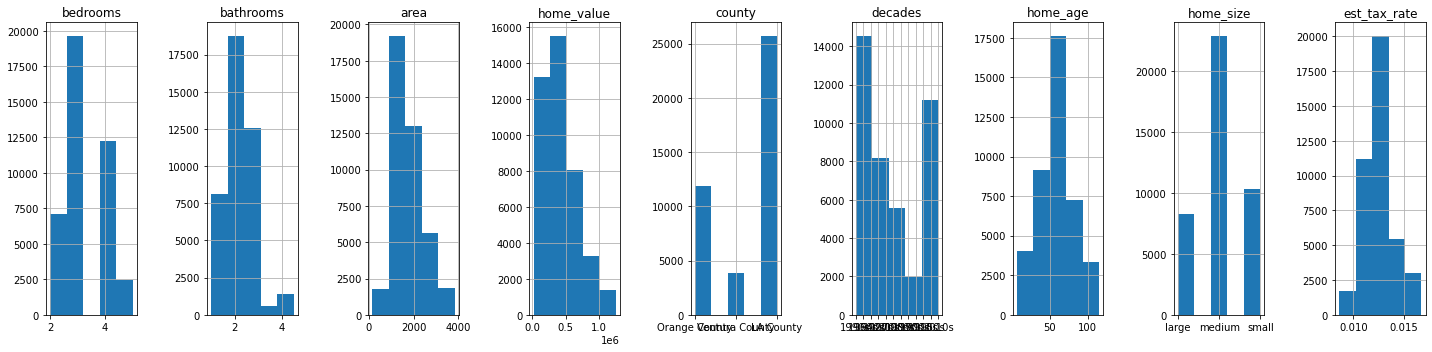

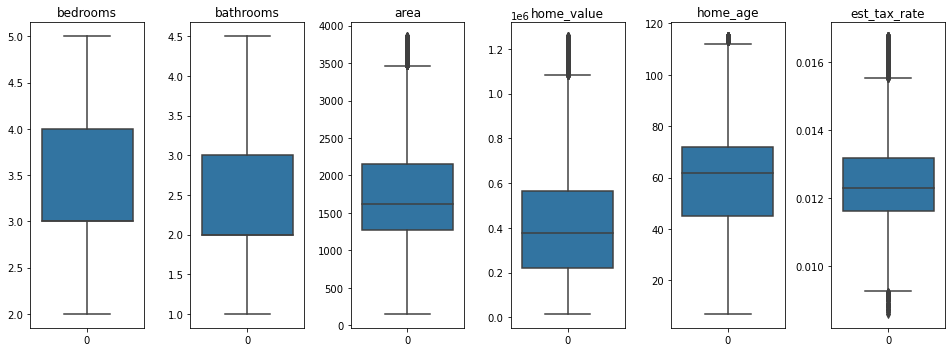

In [2]:
df, train, train_scaled, validate, validate_scaled, test, test_scaled = prep(acquire_zillow())

# Explore 

## Code Moved to wrangle.py ~~Feature Engineering~~

### Decades
    Create columns featuring the decade in which the home was 
    #create list to hold labels for decades
    decade_labels = [x + 's' for x in np.arange(1870, 2030, 10)[:-1].astype('str')]
    #assign decades created from range to new decades column in dataset and apply labels
    train['decades'] = pd.cut(train.year_built, np.arange(1870, 2030, 10), labels=decade_labels, ordered=True)
    plt.figure(figsize=(20,6))
    sns.histplot(train.decades)
### Age
    Create columns that have  the Age 
    train['home_age'] = (2022 - train.year_built).astype('int')
    plt.figure(figsize=(20,6))
    sns.histplot(train.home_age)
### Size 
    Column created to categorize homes by size
    #use quan
    q1, q3 = train.area.quantile([.25, .75])
    train = train.drop(columns='size')
    train['home_size'] = pd.cut(train.area, [0,q1,q3, train.area.max()], labels=['small', 'medium', 'large'], right=True)
    plt.figure(figsize=(20,6))
    sns.countplot(train.home_size) ` 
### Estimated Tax Rate
    Column created to estimate a tax rate based off the home_value divided by the tax rate
    train['est_tax_rate'] = train.tax_amount / train.home_value
    train[train.est_tax_rate > .2]
    plt.figure(figsize=(20,6))
    train.est_tax_rate.hist(bins=20)

## Bivariate - Pairplots 
* Examine variables in relationship to each other

In [3]:
def plot_variable_pairs (df):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe
        Ignores Categorical columns
    
    Parameters
        df: a dataframe containing zillow real estate data

    Returns
        None
    """

    #initialize a seaborn pairgrid
    g = sns.PairGrid(df.select_dtypes(include='number'))
    
    #fills out the pairgrid with a regplot
    g.map(sns.regplot, line_kws={'color':'r'})
    return 

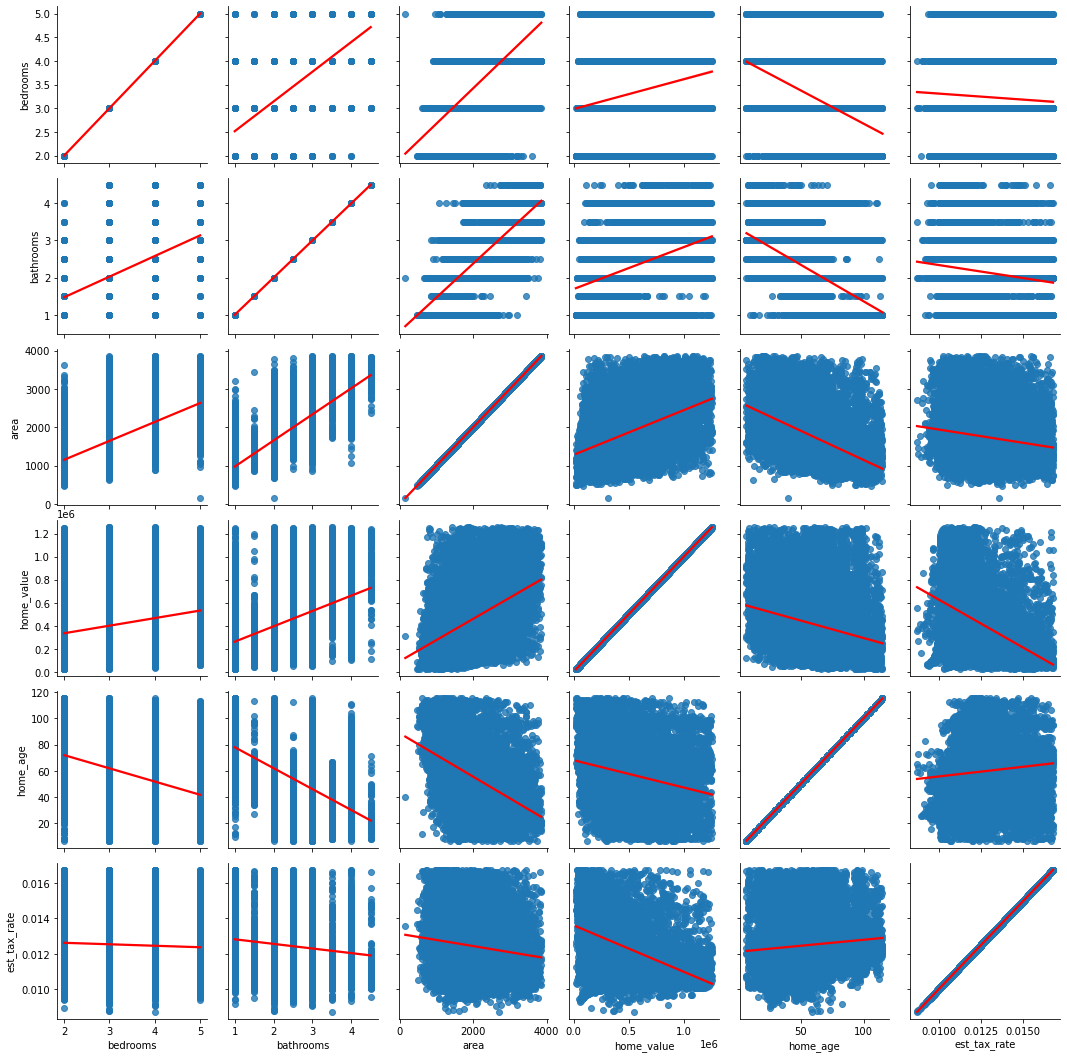

In [4]:
plot_variable_pairs(train)

### Takeaways
> Home_value
- tax_amount highly correlated (removed after 1st MVP)
    - How much correlation? Enough to remove? Worth examining ratio?
    - Tax amount replaced by est tax rate calculation
- home_value more correlated with bathrooms than bedrooms
> Area high correlation with bedrooms and bathrooms
- How much correlation? 
> Estimated Tax Rate - `est_tax_rate`
- negative correlation with home value, bedrooms, and bathrooms
- positive correlation with home age
>Home Age - `home_age`
- higher age associated with smaller homes, less rooms, and a higher tax rate
- those factors appear to negatively correlate with home_value 


## Bivariate - Heatmap

<AxesSubplot:>

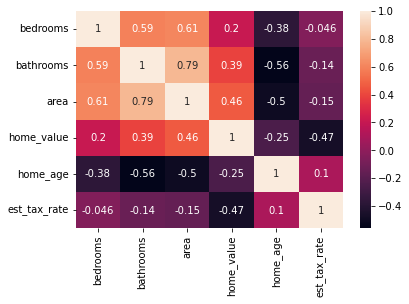

In [5]:
sns.heatmap(data=train.corr(), annot=True)

### Takeaways
* Home Age and Est Tax Rate with negative correlation with almost all 
* Earlier takeaways regarding correlation given additional support
* Take closer look at home_value v

In [6]:
def plot_cat_var_pairs(df):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe utlizing sample size 1000
        Ignores Categorical columns

    Parameters
        df: a dataframe containing zillow real estate data

    Returns
    None
    """

    categorical_col = df.select_dtypes(exclude='number')

    continuous_col = df.select_dtypes(include='number')

    g = sns.PairGrid(data=df, 
                y_vars=continuous_col,
                x_vars=categorical_col, 
                height=4, 
                aspect=2)
    g.map(sns.swarmplot)

    g = sns.PairGrid(data=df, 
                y_vars=continuous_col,
                x_vars='county', 
                height=4, 
                aspect=2)
    g.map(sns.boxplot)

    g = sns.PairGrid(data=df, 
                y_vars=continuous_col,
                x_vars='decades', 
                height=4, 
                aspect=2)

    g.map(sns.barplot)
    
    return

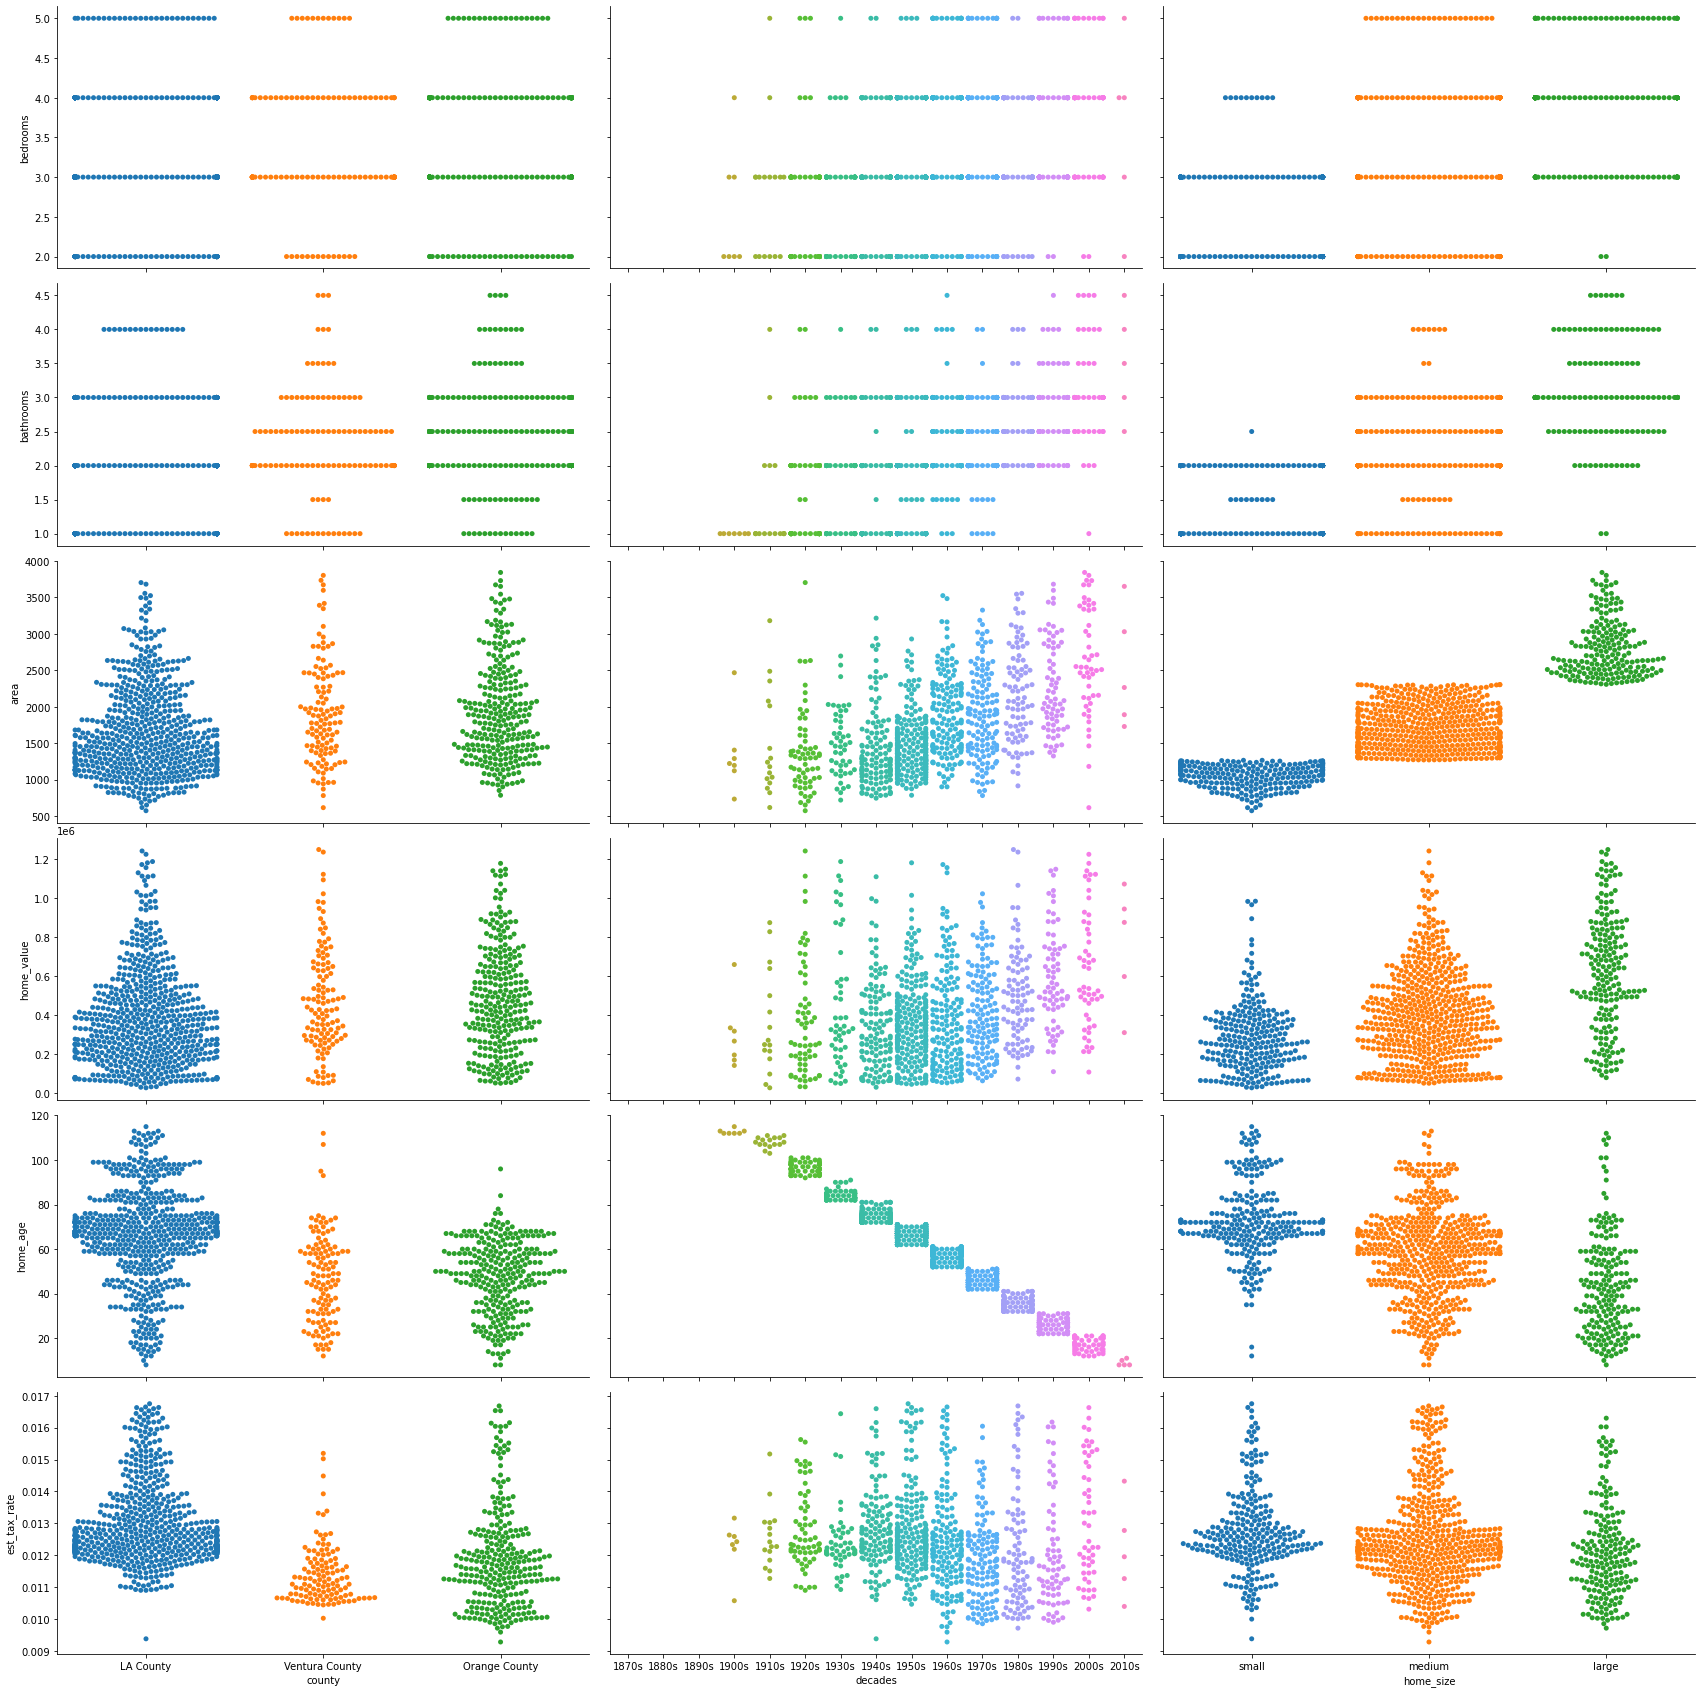

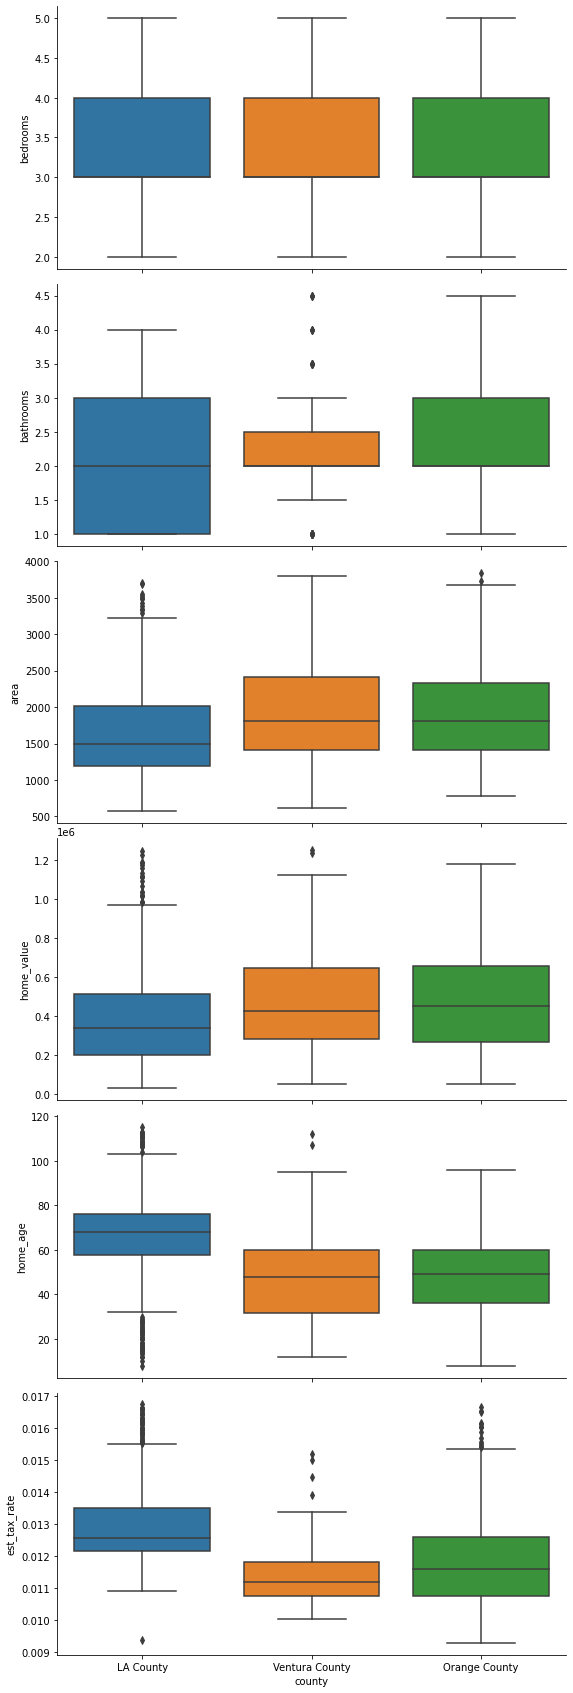

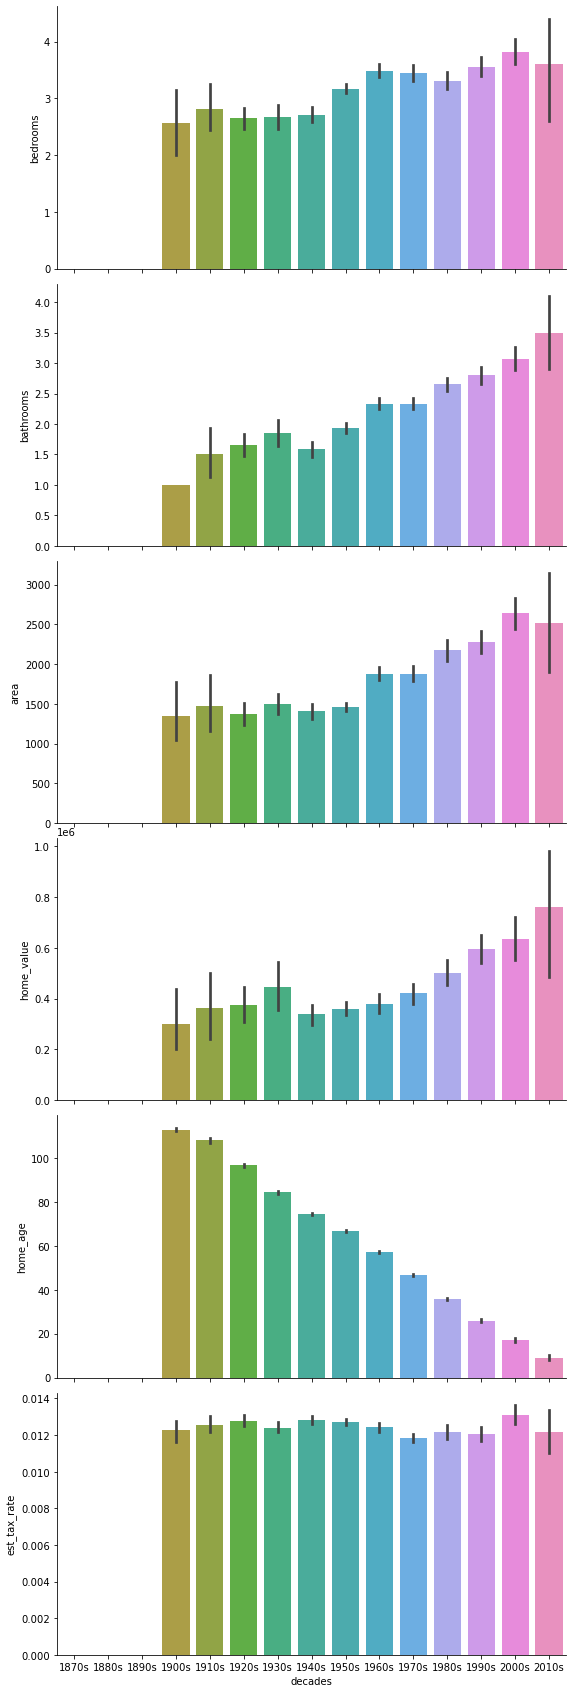

In [7]:
plot_cat_var_pairs(train.sample(n=1000))

### Takeaways
> years_built
- less modern (1985) homes < 3 bedrooms, and less than < 2 bathrooms
- average area of new homes may have risen in past 30 years --> investigate
- tax amount climbing faster than tax value

> County
- LA County bottom heavy in tax_value/tax_amount, as well as largest category 
- Ventura and Orange bedrooms/bathrooms comparable
- Orange County highest mean area


### Home Value vs Everything

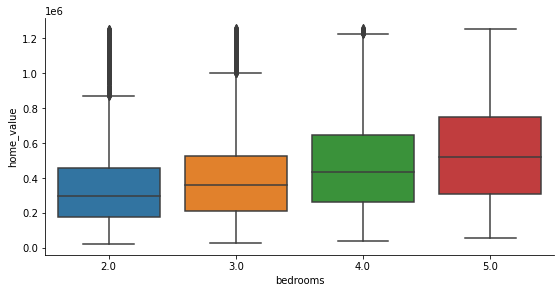

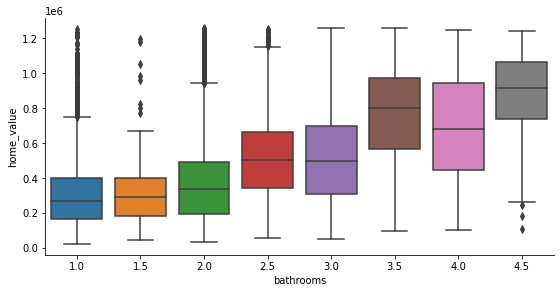

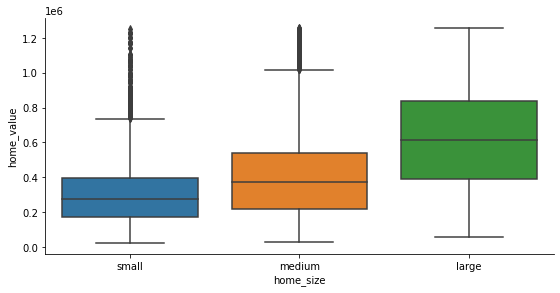

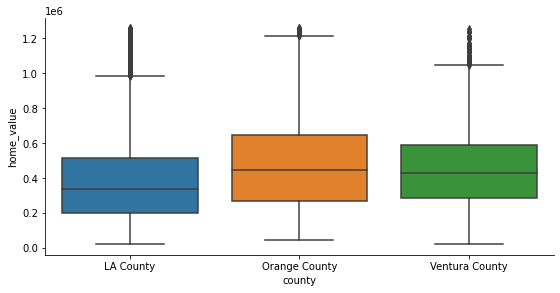

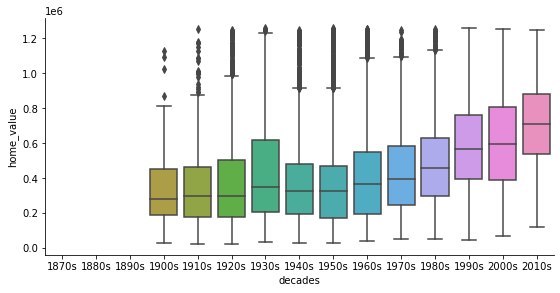

In [82]:
for col in ['bedrooms', 'bathrooms', 'home_size', 'county', 'decades']:
    g = sns.PairGrid(data=train, 
                y_vars='home_value',
                x_vars=col, 
                height=4, 
                aspect=2)
    g.map(sns.boxplot)

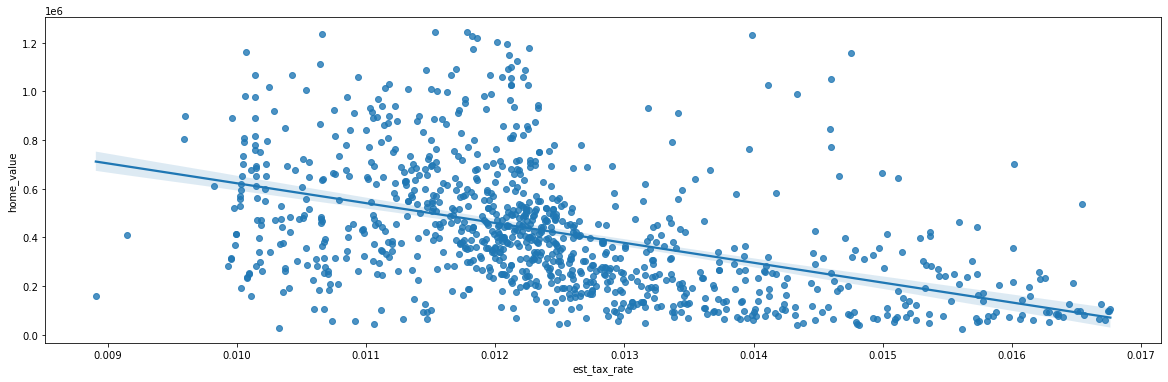

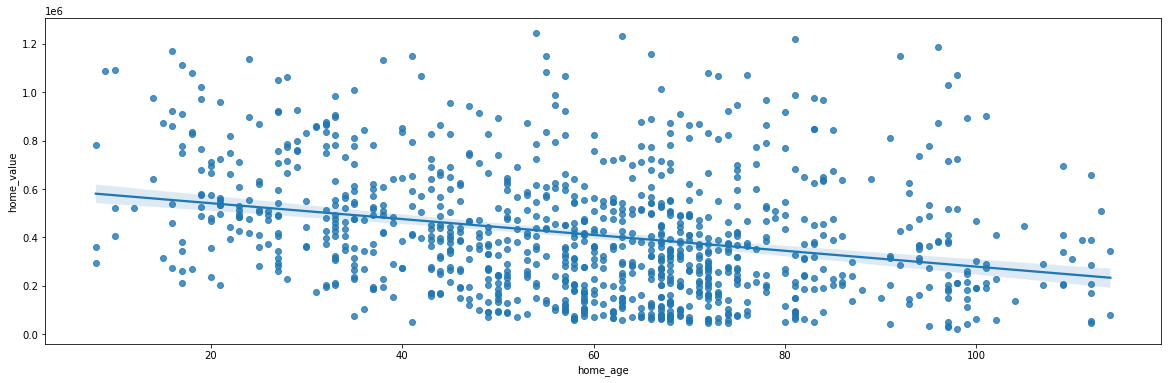

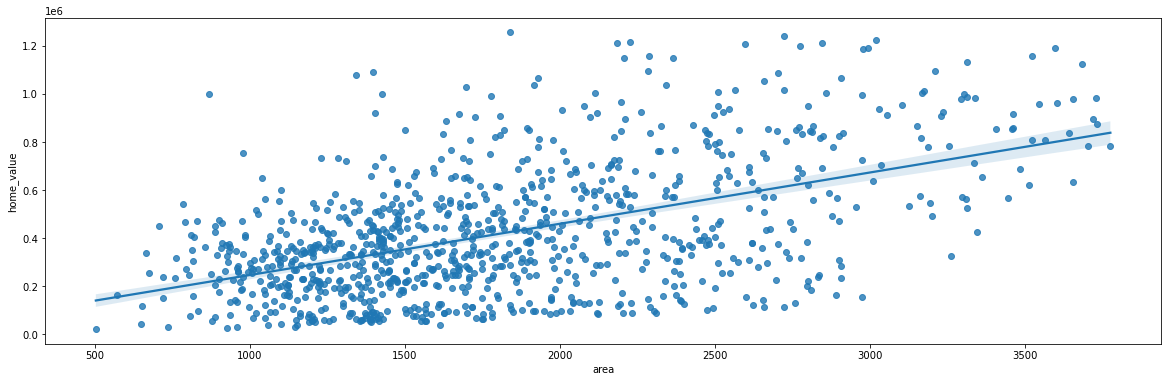

In [9]:
for col in ['est_tax_rate', 'home_age', 'area']:
    plt.figure(figsize=(20,6))
    sns.regplot(data=train.sample(n=1000), y='home_value', x=col)
    plt.show()

### Takeaways
* Bedrooms, bathrooms, home_size/area and lower age support higher home values
* huge jump for value when going above 3 bathrooms
* No other major new takeaways

## Multivariate

### Home Value Vs Home Size Vs The Rest

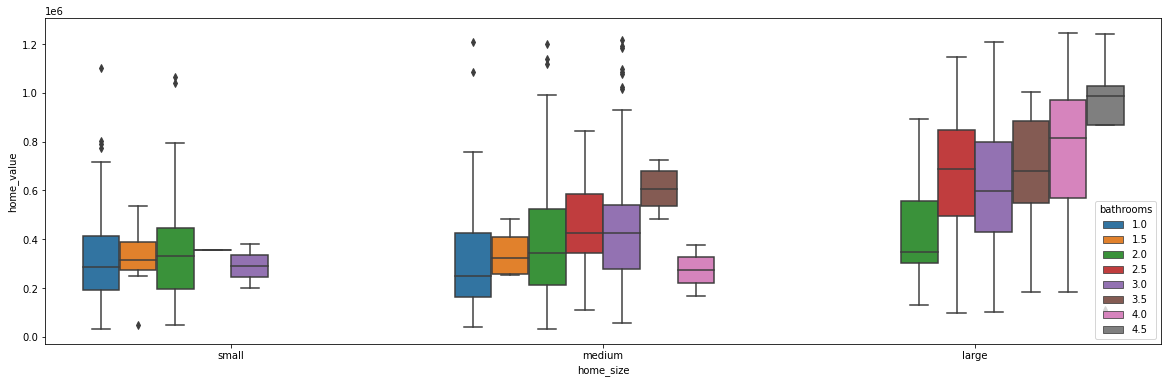

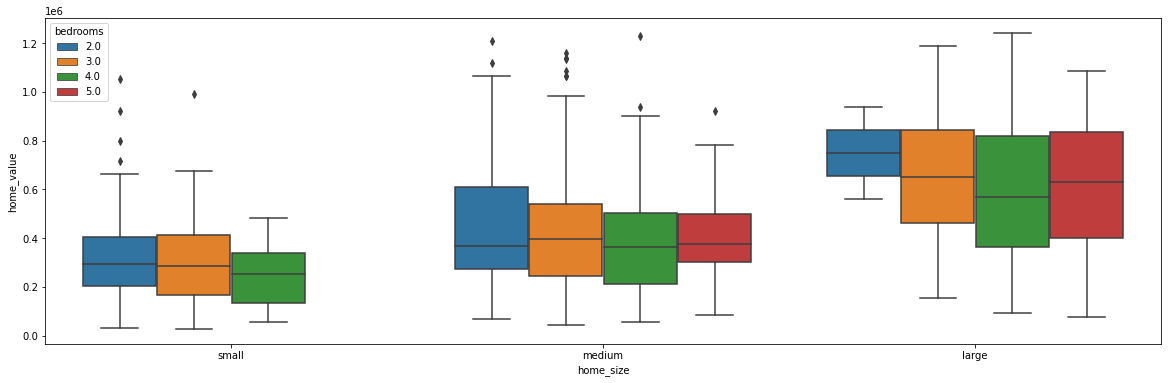

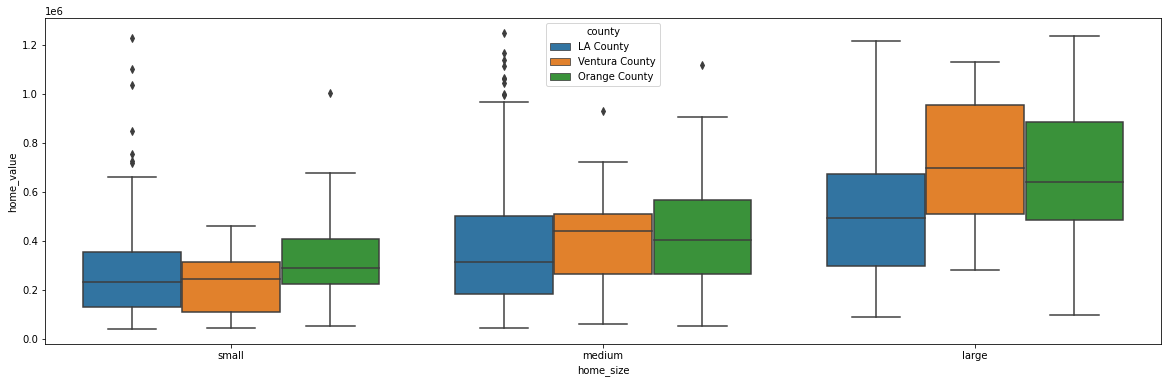

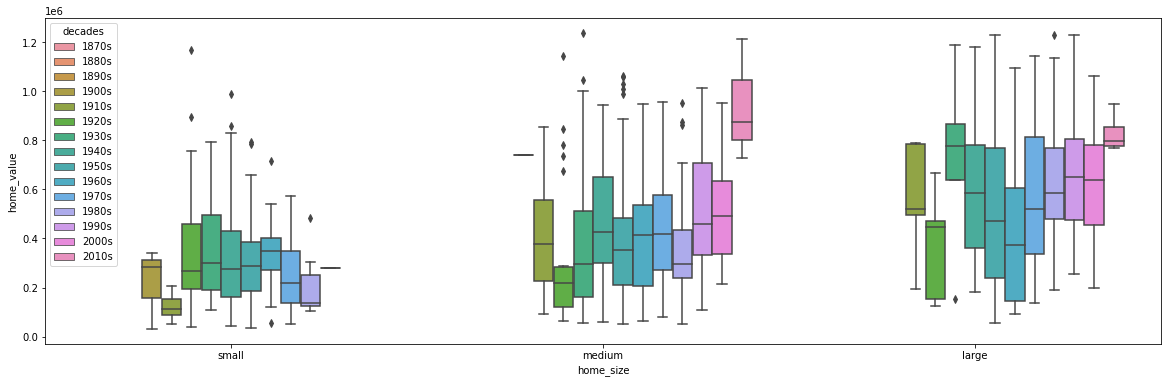

In [10]:
#loop through columns to create visual comparing home values across differences in size groups 
for col in train[['bathrooms', 'bedrooms', 'county', 'decades']].columns:
    plt.figure(figsize=(20,6))
    sns.boxplot(data=train.sample(n=1000), x='home_size', y='home_value',
                hue=col) 
    plt.show()

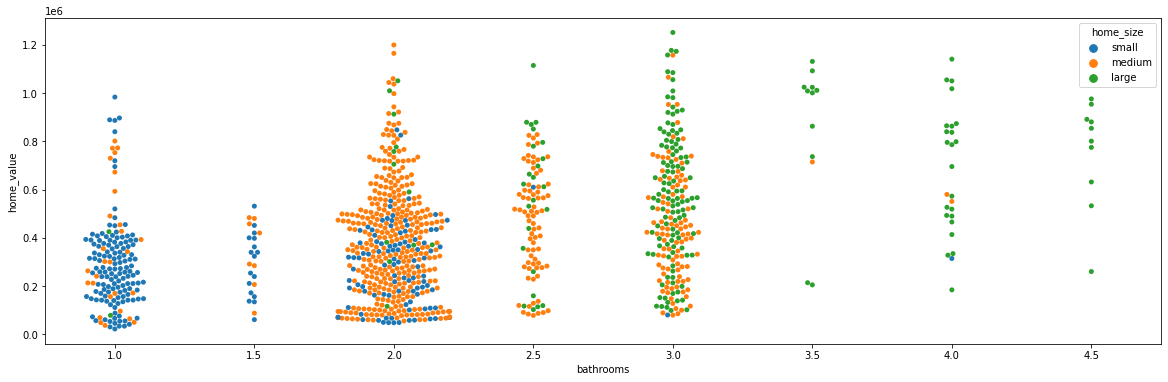

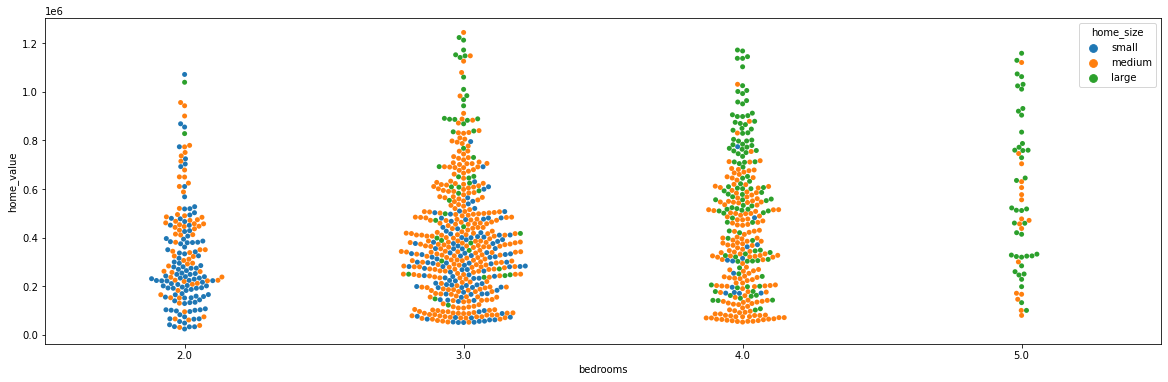

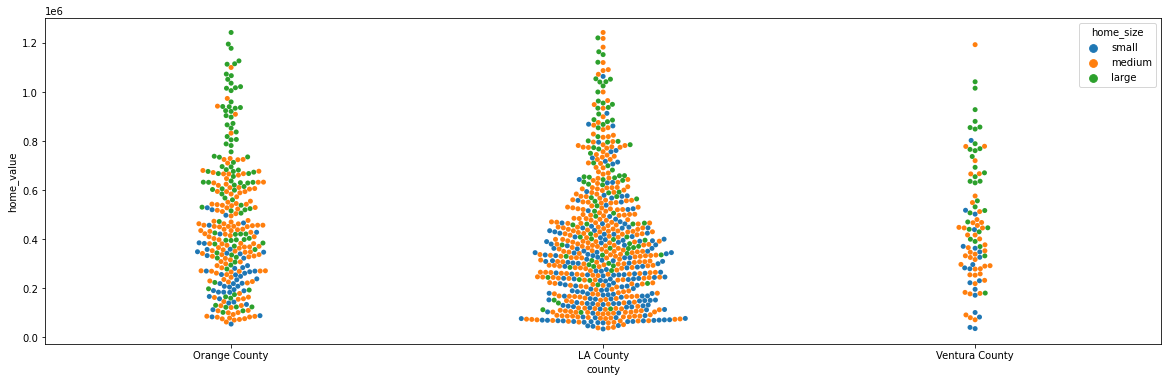

In [11]:
#loop through columns to create visual comparing home values across differences in size groups 
for col in train[['bathrooms', 'bedrooms', 'county']].columns:
    plt.figure(figsize=(20,6))
    sns.swarmplot(data=train.sample(n=1000), x=col, y='home_value',
                hue='home_size') 
    plt.show()

<Figure size 1440x432 with 0 Axes>

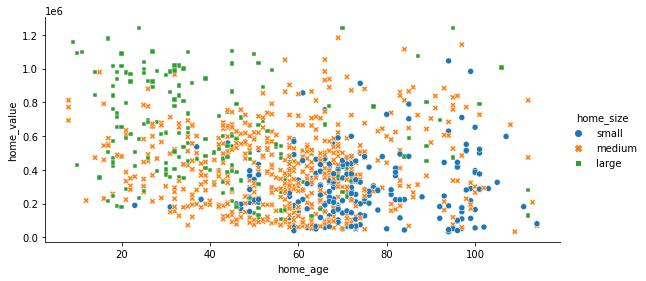

<Figure size 1440x432 with 0 Axes>

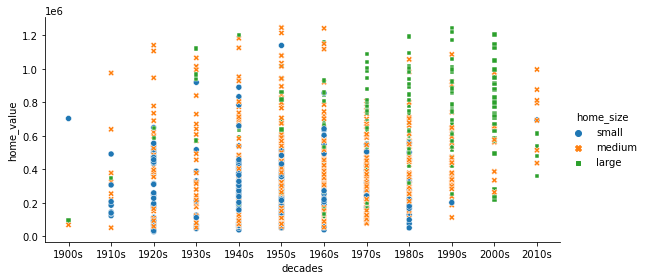

<Figure size 1440x432 with 0 Axes>

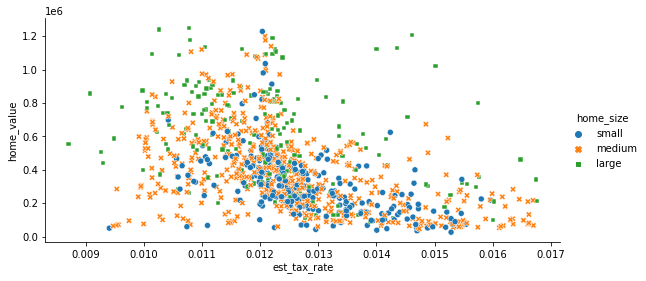

In [12]:
for col in train[['home_age', 'decades', 'est_tax_rate']].columns:
    plt.figure(figsize=(20,6))
    sns.relplot(data=train.sample(n=1000), x=col, y='home_value',
                hue='home_size', style='home_size',
                height=4, aspect=2) 
    plt.show()

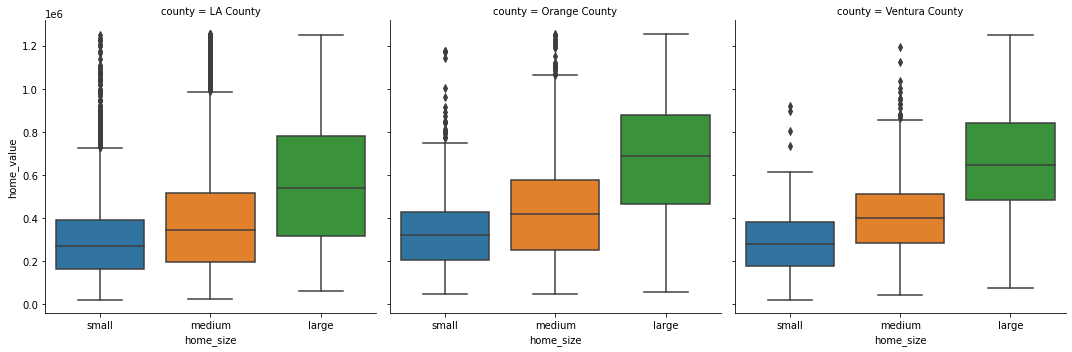

In [13]:
sns.catplot(data=train, x='home_size', y='home_value', col='county', kind='box')

### Takeaways
* The value add of a larger home seems to be consistent rate across counties

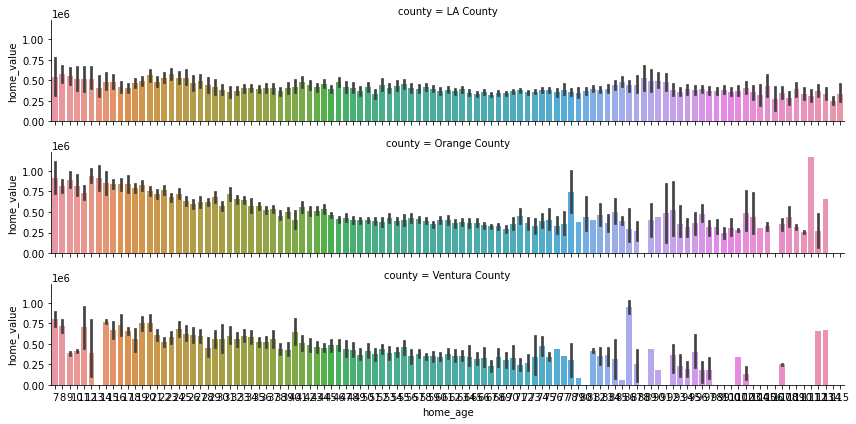

In [14]:
sns.catplot(data=train, x='home_age', y='home_value', row='county', kind='bar', height=2, aspect=6)

## Takeaways
* Large homes less bedrooms are worth more

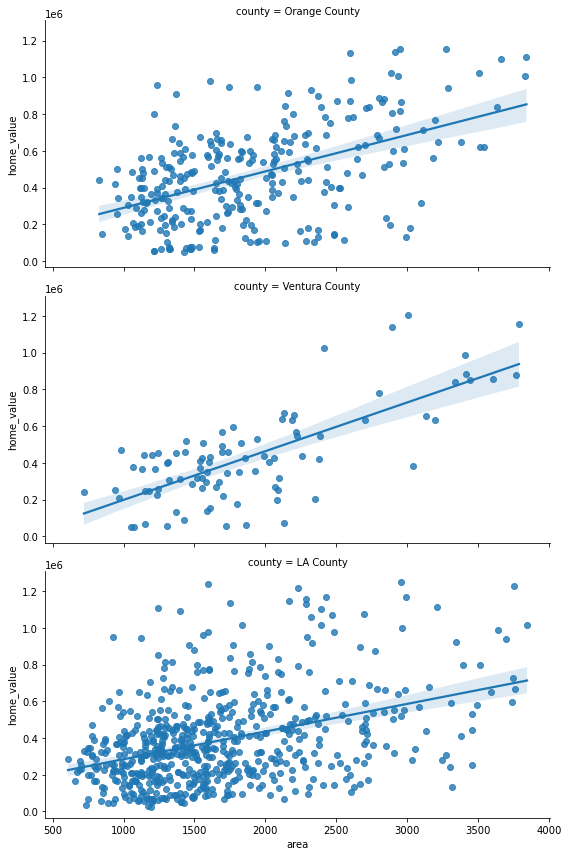

In [15]:
#compare the relationship between home value and area across the different counties
sns.lmplot(data=train.sample(n=1000), x='area', y='home_value', row='county', height=4, aspect=2)

### Takeaways
* not very large discrepencies between the counties based on bathrooms or bedrooms.
* nothing very interesting here 

### Home Value Vs Home Age Vs The Rest

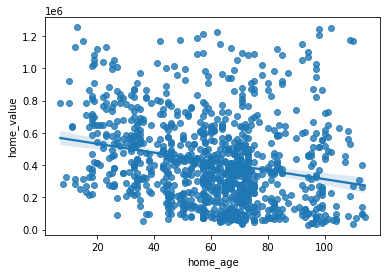

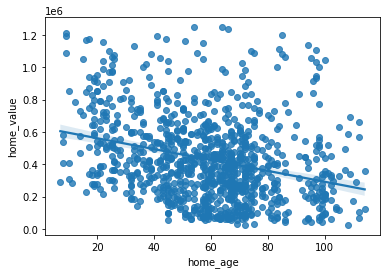

In [16]:
for col in train[['bathrooms', 'bedrooms']].columns:
    sns.regplot(data=train.sample(n=1000), x='home_age', y='home_value',
                )
    plt.show()

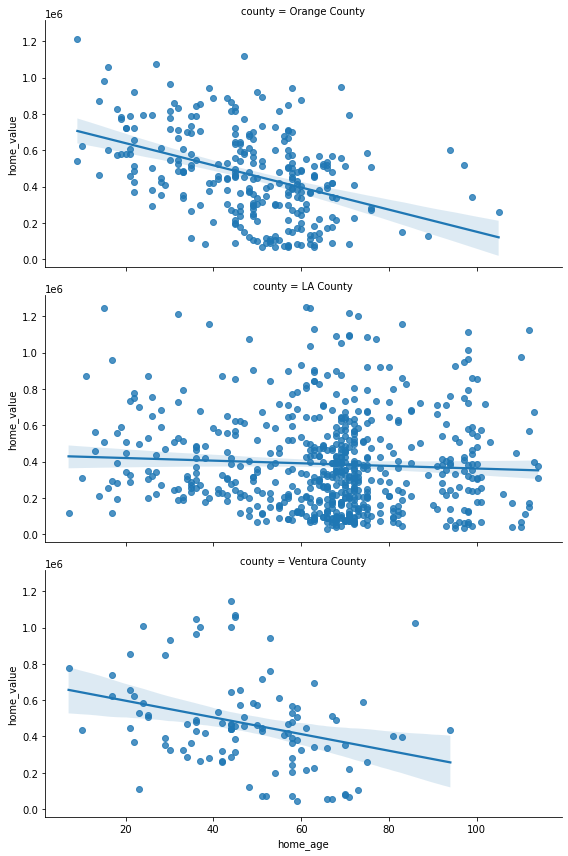

In [17]:
sns.lmplot(data=train.sample(n=1000), x='home_age', y='home_value', row='county', height=4, aspect=2)

## Takeaways
* Newer Homes in LA County not seeing the same rise in value

### Home Value seperated by County Vs The Rest

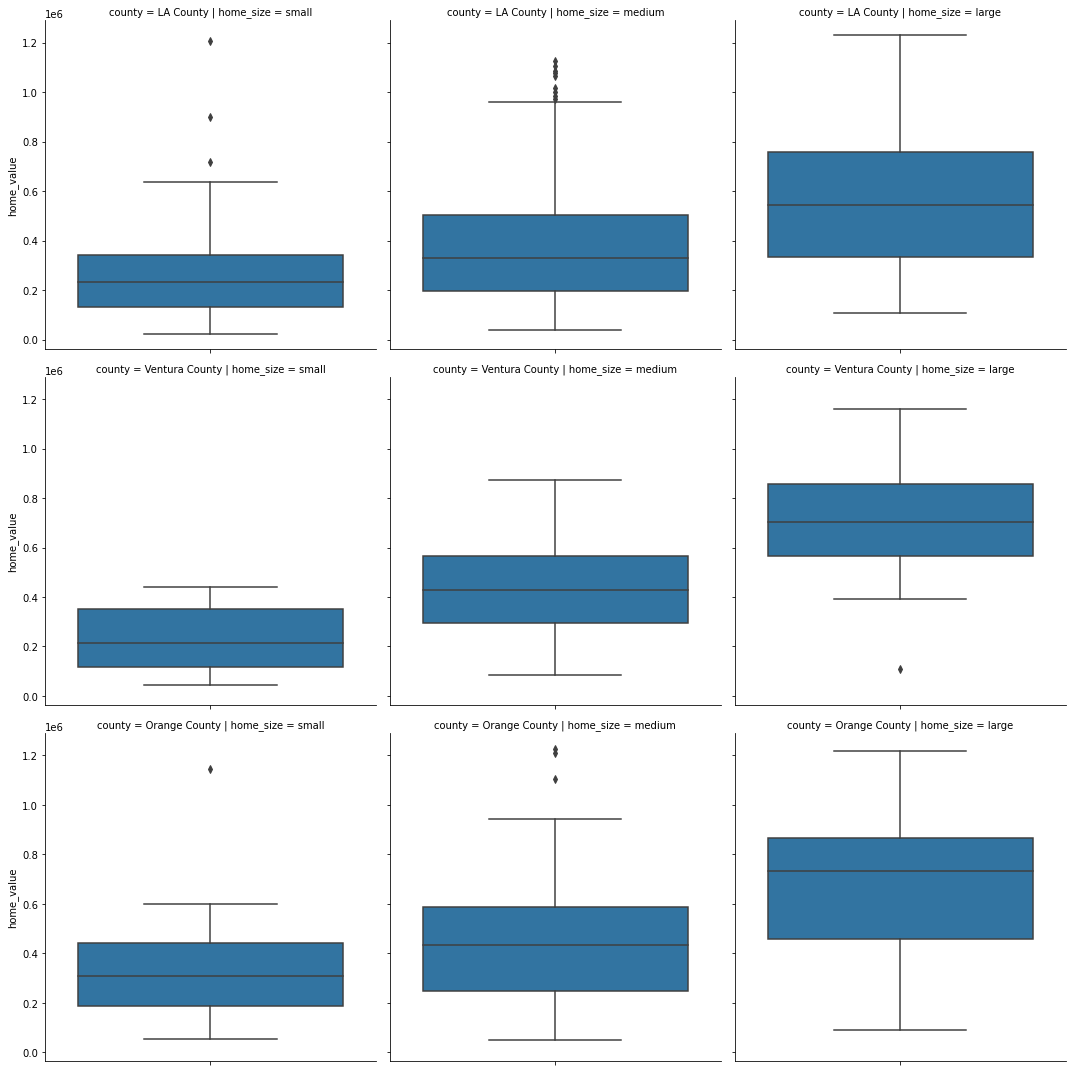

In [24]:
sns.catplot(data=train.sample(n=1000), y='home_value', col='home_size', row='county', kind='box');

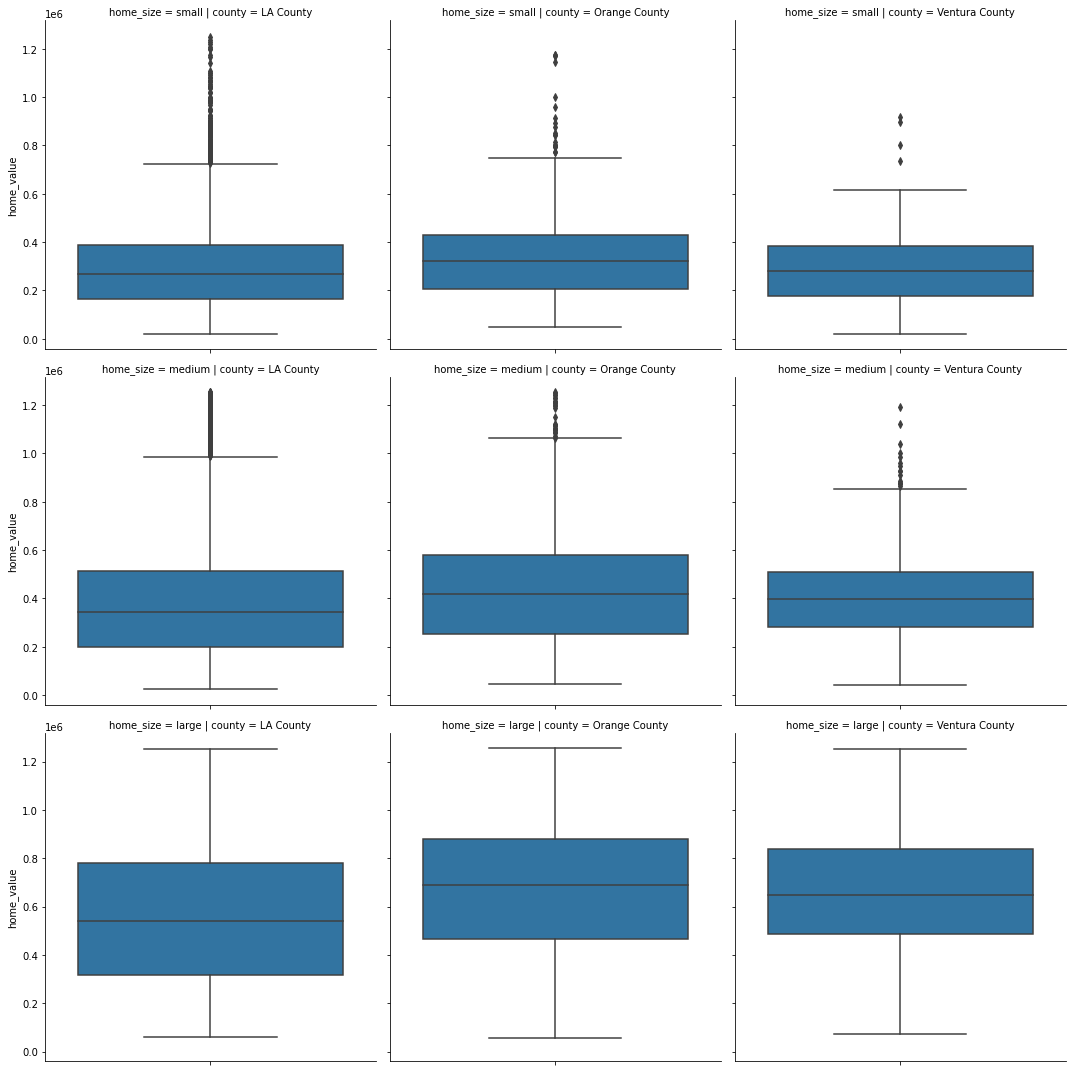

In [51]:
sns.catplot(data=train, y='home_value', col='county', row='home_size', kind='box');

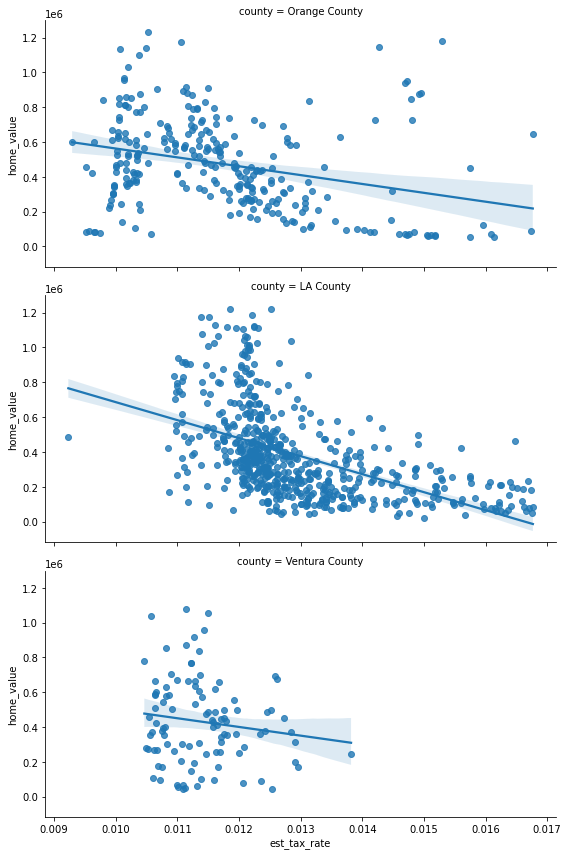

In [18]:

sns.lmplot(data=train.sample(n=1000), x='est_tax_rate', y='home_value', row='county', height=4, aspect=2)

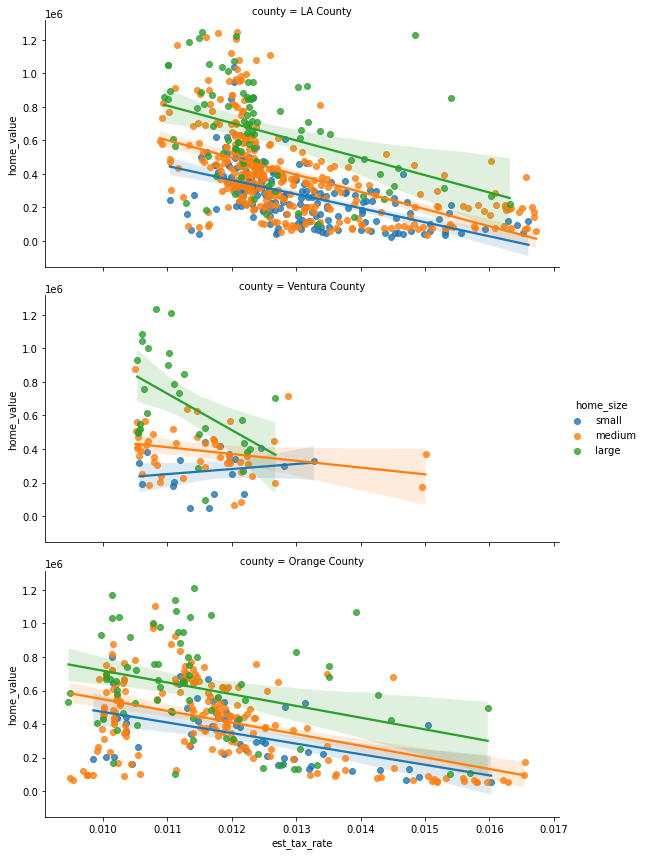

In [19]:
# tax rate relationship holds across counties
sns.relplot(data=train.sample(n=1000), x='est_tax_rate', y='home_value', hue='home_size', row='county', height=4, aspect=2)

## Takeaways
* LA county larger effect of est_tax_rate on decrease in home values
* Ventura

## Specific Questions with plots and tests

### Question - Is there difference in median home value between counties?
${H_0}$: There is no significant difference in median home value between counties  
${H_a}$: There is significant difference in median home value between counties  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [33]:
round(train.groupby(by='county').home_value.mean().sort_values(ascending=False) ,2)

county
Orange County     473224.36
Ventura County    452303.54
LA County         384579.03
Name: home_value, dtype: float64

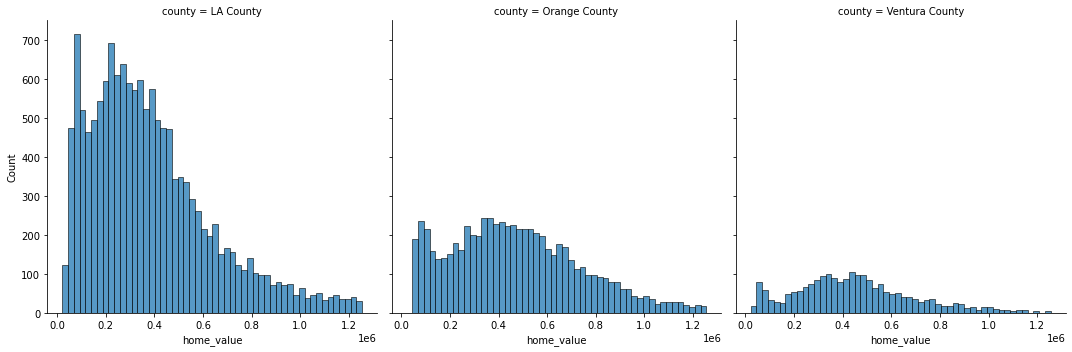

In [20]:
#visualization first
sns.displot(data=train, x='home_value', col='county', kind='hist');

In [21]:
#fips 6059 has highest mean value --> for variances what is the threshold for useability?
la_county = train[train.county == 'LA County'].home_value
orange_county = train[train.county == 'Orange County'].home_value
ventura_county = train[train.county == 'Ventura County'].home_value

alpha = .05
f, p = f_oneway(la_county, orange_county, ventura_county)

print (f'ANOVA test statistic value: {f}')
print (f'p-value : {p}')

if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

ANOVA test statistic value: 296.5808060407762
p-value : 6.552208990337671e-128
There is enough evidence to reject our null hypothesis


### Question -  Why do some properties have a much higher value than others when they are located so close to each other? 

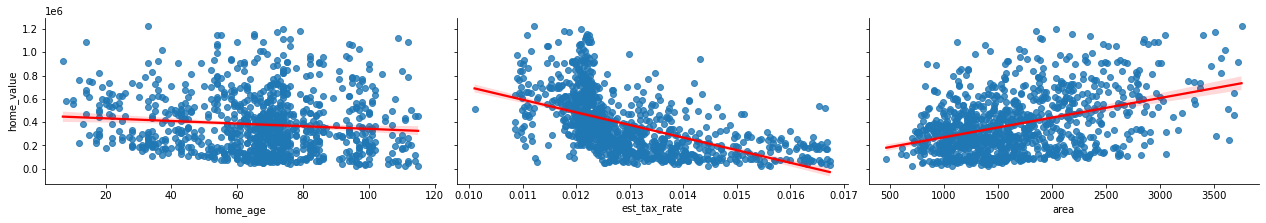

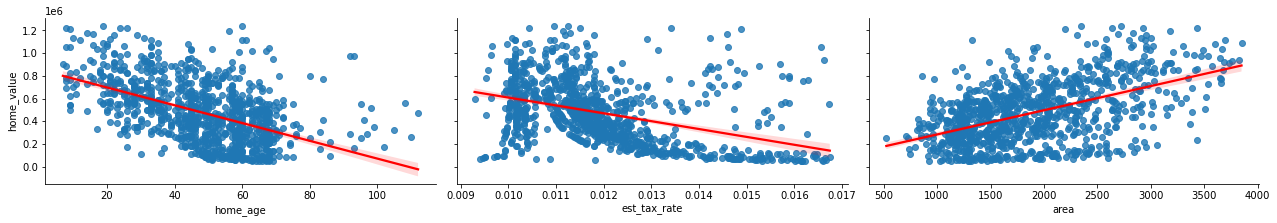

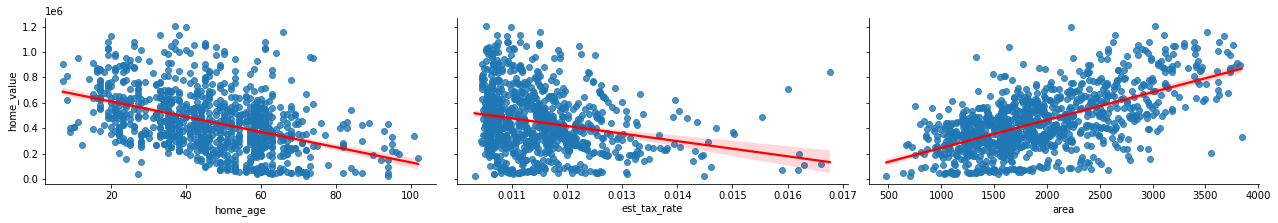

In [62]:
for county in ['LA County', 'Orange County', 'Ventura County']:
    g = sns.PairGrid(data=train[train.county == county].sample(n=1000),
                    y_vars='home_value', x_vars=['home_age', 'est_tax_rate', 'area'],
                    height=3, aspect=2)
    g.map(sns.regplot, line_kws={'color':'r'}, label=county)

In [83]:
alpha = .05
for col in ['home_age', 'est_tax_rate', 'area']:
    r, p = pearsonr(train[col], train.home_value)
    if p > alpha:
        result = 'Fail to reject the null hypothesis, because our p-value is greater than our alpha.'
    else: 
        result = 'There is enough evidence to reject our null hypothesis'

    print(f""" 
    H_0: There is no relationship between median home value and {col}
    H_a: There is a relationship between median home value and {col}
    alpha: .05
    Pearson r value: {r}
    p-value : {p}
    {result}
    -----""")

 
    H_0: There is no relationship between median home value and home_age
    H_a: There is a relationship between median home value and home_age
    alpha: .05
    Pearson r value: -0.251367782193178
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
 
    H_0: There is no relationship between median home value and est_tax_rate
    H_a: There is a relationship between median home value and est_tax_rate
    alpha: .05
    Pearson r value: -0.4692591801779151
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
 
    H_0: There is no relationship between median home value and area
    H_a: There is a relationship between median home value and area
    alpha: .05
    Pearson r value: 0.46319756420051295
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----


In [43]:
# area has a high correlation with property value
alpha = .05
for county in ['LA County', 'Orange County', 'Ventura County']:
    print(f'In {county}:')
    for col in ['home_age', 'est_tax_rate', 'area']:
        r, p = pearsonr(train[train.county == county][col], train[train.county == county].home_value)
        if p > alpha:
            result = 'Fail to reject the null hypothesis, because our p-value is greater than our alpha.'
        else: 
            result = 'There is enough evidence to reject our null hypothesis'

        print(f""" 
        H_0: There is no relationship between median home value and {col}
        H_a: There is a relationship between median home value and {col}
        alpha: .05
        Pearson r value: {r}
        p-value : {p}
        {result}
        -----""")

In LA County:
 
        H_0: There is no significant difference in median home value among home_age
        H_a: There is significant difference in median home value among home_age
        alpha: .05
        Pearson r value: -0.08466487313626364
        p-value : 3.2328506334010425e-24
        There is enough evidence to reject our null hypothesis
        -----
 
        H_0: There is no significant difference in median home value among est_tax_rate
        H_a: There is significant difference in median home value among est_tax_rate
        alpha: .05
        Pearson r value: -0.5209255495897032
        p-value : 0.0
        There is enough evidence to reject our null hypothesis
        -----
 
        H_0: There is no significant difference in median home value among area
        H_a: There is significant difference in median home value among area
        alpha: .05
        Pearson r value: 0.3817707752076994
        p-value : 0.0
        There is enough evidence to reject our null hy

### Question -  Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location?



In [80]:
round(train.groupby(by='county').est_tax_rate.mean().sort_values(ascending=False) ,3)

county
LA County         0.013
Orange County     0.012
Ventura County    0.011
Name: est_tax_rate, dtype: float64

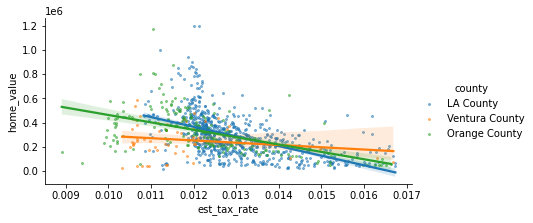

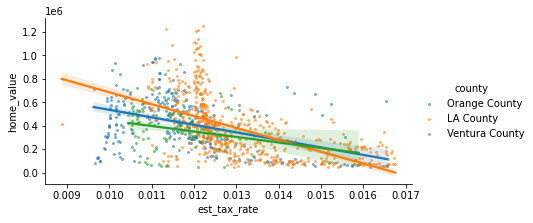

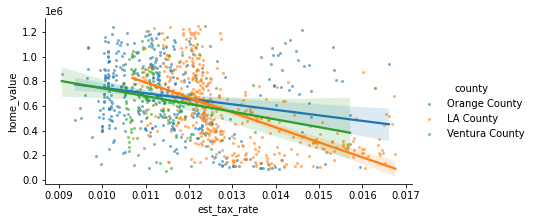

In [78]:
for size in ['small', 'medium', 'large']:
    g = sns.PairGrid(data=train[train.home_size == size].sample(n=1000),
                    y_vars='home_value', x_vars=['est_tax_rate'],
                    hue='county', height=3, aspect=2)
    g.map(sns.regplot, scatter_kws = {'alpha': 0.5,'s':4})
    g.add_legend()

In [84]:
# area has a high correlation with property value
alpha = .05
for size in ['small', 'medium', 'large']:
    print(f'In {size}:')
    r, p = pearsonr(train[train.home_size == size]['est_tax_rate'], train[train.home_size == size].home_value)
    if p > alpha:
        result = 'Fail to reject the null hypothesis, because our p-value is greater than our alpha.'
    else: 
        result = 'There is enough evidence to reject our null hypothesis'

    print(f""" 
    H_0: There is no relationship between median home value and {col}
    H_a: There is a relationship between median home value and {col}
    alpha: .05
    Pearson r value: {r}
    p-value : {p}
    {result}
    -----""")

In small:
 
    H_0: There is no relationship between median home value and area
    H_a: There is a relationship between median home value and area
    alpha: .05
    Pearson r value: -0.495171052696178
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
In medium:
 
    H_0: There is no relationship between median home value and area
    H_a: There is a relationship between median home value and area
    alpha: .05
    Pearson r value: -0.49317912485896725
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
In large:
 
    H_0: There is no relationship between median home value and area
    H_a: There is a relationship between median home value and area
    alpha: .05
    Pearson r value: -0.36722405188931806
    p-value : 3.824945187982036e-148
    There is enough evidence to reject our null hypothesis
    -----


### Question - Is having one bathroom worse than having two bedrooms?


In [22]:
#create series containing the home values of the subgroups in question
one_bathroom = train[train.bathrooms == 1].home_value
two_bedrooms = train[train.bedrooms == 2].home_value

In [23]:
print(f'Mean home value of homes with one bathroom: {round(one_bathroom.mean(),2)}\n\
Mean home value of homes with two bedrooms: {round(two_bedrooms.mean(),2)}')

Mean home value of homes with one bathroom: 301604.7
Mean home value of homes with two bedrooms: 343753.04


In [24]:
#set alpha
alpha = .05

#perform levene tets
l, p = levene(one_bathroom, two_bedrooms)

print (f'Levene test statistic value: {f}')
print (f'p-value : {p}')

#check p against alpha
if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

Levene test statistic value: 296.5808060407762
p-value : 2.1705383432926296e-15
There is enough evidence to reject our null hypothesis


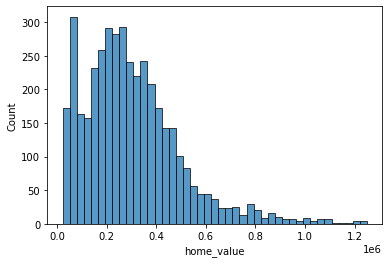

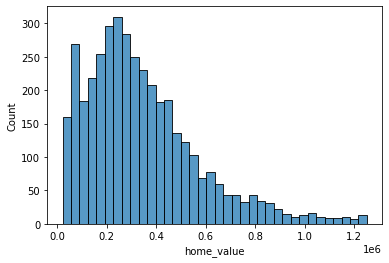

In [25]:
sns.histplot(one_bathroom);

plt.show()

sns.histplot(two_bedrooms);


#### Statistical Testing
${H_0}$: The mean home value of homes with 1 bathroom is equal or greater than those with 2 bedrooms  
${H_a}$: The mean home value of homes with 1 bathroom is less than those with 2 bedrooms   
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [26]:
alpha = .05
t, p = ttest_ind(one_bathroom, two_bedrooms, equal_var=False)

print (f't test statistic value: {f}')
print (f'p-value : {p}')

if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

t test statistic value: 296.5808060407762
p-value : 1.35684620954748e-18
There is enough evidence to reject our null hypothesis


# Model
Using scaled dataset

In [27]:
# create X,y for train, validate and test subsets
X_train = train_scaled.drop(columns='home_value')
y_train = train.home_value
X_val = validate_scaled.drop(columns='home_value')
y_val = validate.home_value
X_test = test_scaled.drop(columns='home_value')
y_test = test_scaled.home_value

In [28]:
#shift y subsets into a data frame
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

In [29]:
#get dummies for X subsets
X_train = pd.get_dummies(X_train, columns=['county', 'home_size', 'decades'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['county', 'home_size', 'decades'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['county', 'home_size', 'decades'], drop_first=True)

In [30]:
#set list of up for features
all_features = list(X_train.columns)

req_features  = ['area', 'bedrooms', 'bathrooms']

feat_set1  = ['est_tax_rate', 'area']

feat_set2 = ['est_tax_rate', 'area', 'home_age']

feat_combos = [all_features, req_features, feat_set1, feat_set2]

In [31]:
#baseline --> choose median because data is scaled

#add baseline columns
y_train['pred_median'] = y_train.home_value.median()
y_val['pred_median'] = y_val.home_value.median()

#add/calc RMSEs for median baseline predictions
rmse_train = mean_squared_error(y_train.home_value, y_train.pred_median, squared=False)
rmse_val = mean_squared_error(y_val.home_value, y_val.pred_median, squared=False)

print(f'RMSEs: Median\n Train/In Sample: {round(rmse_train, 2)}\n Validate/Out of Sample: {round(rmse_val, 2)}')



RMSEs: Median
 Train/In Sample: 262759.24
 Validate/Out of Sample: 265031.73


#PF

In [32]:
def pf_mod(X, y, selectors, fit_train=None, fit_y_train=None):

    for idx, combo in enumerate(selectors):
        pf = PolynomialFeatures(degree=combo[1])

        lm = LinearRegression(normalize=True)

        if fit_train is not None:
            fit_pf = pf.fit_transform(fit_train[combo[0]])
            X_pf = pf.transform(X[combo[0]])  
            lm.fit(fit_pf, fit_y_train.home_value)
        else:
            X_pf = pf.fit_transform(X[combo[0]])
            lm.fit(X_pf, y.home_value)

        model_label = f'Polynomial_{idx+1}'

        #predict train
        y[model_label] = lm.predict(X_pf) 

        #calculate train rmse
        rmse = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'{model_label} with degree: {combo[1]} \n\
            Features: {combo[0]} \n\
            RMSE: {rmse}\n')

    return

In [33]:
#create a list of parameters
pf_parameters = [2,3]

#use list with product to create tuples of feature/parameter combination to feed into model
selectors = list(product(feat_combos, pf_parameters))

#call pf function to get predictions for the Polynomial models and add to the dataframe
pf_mod(X_train, y_train, selectors)

Polynomial_1 with degree: 2 
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s'] 
            RMSE: 185146.3346220901

Polynomial_2 with degree: 3 
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s'] 
            RMSE: 174798.93450586035

Polynomial_3 with degree: 2 
            Feat

In [34]:
def ols_mod(X, y, selectors, fit_x_train=None, fit_y_train=None):

    for idx, features in enumerate(selectors):  
        lm = LinearRegression()
    
        model_label = f'OLS_{idx+1}'

        if fit_x_train is not None:
            lm.fit(fit_x_train[features], fit_y_train.home_value)
        else:   
            lm.fit(X[features], y.home_value)

        #predict train
        y[model_label] = lm.predict(X[features]) 

        #calc trian rmse
        rmse_train = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'{model_label} with LinearRegression\n\
            Features: {features}\n\
            RMSE: {rmse_train}\n')

    return

In [35]:
#run ols model with feature combinations
ols_mod(X_train, y_train, feat_combos)

OLS_1 with LinearRegression
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s']
            RMSE: 196480.94377265047

OLS_2 with LinearRegression
            Features: ['area', 'bedrooms', 'bathrooms']
            RMSE: 227846.126655523

OLS_3 with LinearRegression
            Features: ['est_tax_rate', 'area']
            RMSE: 204760.86644507793

OLS_4 with LinearRegression
            Features: ['est_tax_rate', 'area', 'home_age']
            RMSE: 204739.34584345898



In [36]:
def lars_mod(X, y, selectors):

    for idx, combo in enumerate(selectors):  
        lars = LassoLars(alpha=combo[0])
    
        model_label = f'LARS_{idx+1}'

        #fit mode 
        lars.fit(X, y.home_value)

        #predict train
        y[model_label] = lars.predict(X) 

        #calc trian rmse
        rmse_train = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'RMSE for {model_label} with Alpha: {combo[0]}\n\
            Features:{combo[1]}\n\
            Training/In-Sample: {rmse_train}\n')


In [37]:
#create a list of parameters
lars_parameters = [.25, .5, .75, 1]

#use list with product to create tuples of feature/parameter combination to feed into model
selectors = list(product(lars_parameters, feat_combos))

lars_mod(X_train, y_train, selectors)

RMSE for LARS_1 with Alpha: 0.25
            Features:['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s']
            Training/In-Sample: 196474.58413539344

RMSE for LARS_2 with Alpha: 0.25
            Features:['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 196474.58413539344

RMSE for LARS_3 with Alpha: 0.25
            Features:['est_tax_rate', 'area']
            Training/In-Sample: 196474.58413539344

RMSE for LARS_4 with Alpha: 0.25
            Features:['est_tax_rate', 'area', 'home_age']
            Training/In-Sample: 196474.58413539344

RMSE for LARS_5 with Alpha: 0.5
            Features:['bedrooms', 'bathrooms', 'area', 'home

In [38]:
def GLM_mod(X, y, selectors):

    for idx, combo in enumerate(selectors):  
        glm = TweedieRegressor(power=combo[0][0], alpha=combo[0][1])
    
        model_label = f'GLM_{idx+1}'

        #fit mode 
        glm.fit(X, y.home_value)

        #predict train
        y[model_label] = glm.predict(X) 

        #calc trian rmse
        rmse_train = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'{model_label} with Tweedie \n\
            Power: {combo[0][0]}, alpha: {combo[0][1]}\n\
            Features: {combo[1]} \n\
            RMSE: {rmse_train}')

    return


In [39]:
#create a list of parameters
glm_parameters = [(0,1), (0,.25), (0,.5), (0,.75), (0,1)]

#use list with product to create tuples of feature/parameter combination to feed into model
selectors = list(product(glm_parameters, feat_combos))

GLM_mod(X_train, y_train, selectors)

GLM_1 with Tweedie 
            Power: 0, alpha: 1
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s'] 
            RMSE: 247409.82719701933
GLM_2 with Tweedie 
            Power: 0, alpha: 1
            Features: ['area', 'bedrooms', 'bathrooms'] 
            RMSE: 247409.82719701933
GLM_3 with Tweedie 
            Power: 0, alpha: 1
            Features: ['est_tax_rate', 'area'] 
            RMSE: 247409.82719701933
GLM_4 with Tweedie 
            Power: 0, alpha: 1
            Features: ['est_tax_rate', 'area', 'home_age'] 
            RMSE: 247409.82719701933
GLM_5 with Tweedie 
            Power: 0, alpha: 0.25
            Featur

In [40]:
round(y_train, 2)

,home_value,pred_median,Polynomial_1,Polynomial_2,Polynomial_3,Polynomial_4,Polynomial_5,Polynomial_6,Polynomial_7,Polynomial_8,...,GLM_11,GLM_12,GLM_13,GLM_14,GLM_15,GLM_16,GLM_17,GLM_18,GLM_19,GLM_20
45341,431694.0,373989.5,373216.0,330720.0,363418.37,358375.88,347863.35,337336.63,329987.95,318631.09,...,388190.64,388190.64,395032.89,395032.89,395032.89,395032.89,399183.07,399183.07,399183.07,399183.07
26114,170492.0,373989.5,416480.0,404384.0,495216.31,499339.22,536976.73,568801.75,517998.61,527178.82,...,483975.03,483975.03,469526.32,469526.32,469526.32,469526.32,460110.56,460110.56,460110.56,460110.56
25346,90249.0,373989.5,158112.0,98752.0,303494.76,301768.61,207703.42,143567.11,189112.61,144151.12,...,374568.67,374568.67,385398.50,385398.50,385398.50,385398.50,391733.36,391733.36,391733.36,391733.36
1070,535719.0,373989.5,528352.0,526304.0,465719.40,448288.68,518381.05,536139.21,489894.88,496312.50,...,473628.04,473628.04,461225.29,461225.29,461225.29,461225.29,453206.67,453206.67,453206.67,453206.67
32141,124863.0,373989.5,427744.0,373664.0,543954.71,545801.98,487375.49,451264.52,427517.24,380734.80,...,465714.14,465714.14,455275.36,455275.36,455275.36,455275.36,448433.11,448433.11,448433.11,448433.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16649,249548.0,373989.5,458720.0,502240.0,511476.76,518315.85,578609.79,624966.11,569145.77,583312.27,...,493976.64,493976.64,477035.49,477035.49,477035.49,477035.49,466119.31,466119.31,466119.31,466119.31
29035,381287.0,373989.5,396704.0,386752.0,349982.15,344369.33,374719.83,394495.24,362630.01,386274.00,...,378595.82,378595.82,386416.51,386416.51,386416.51,386416.51,391631.29,391631.29,391631.29,391631.29
19517,93631.0,373989.5,180192.0,126624.0,267704.60,267139.25,234865.48,226469.26,320211.02,167095.57,...,373263.48,373263.48,384455.22,384455.22,384455.22,384455.22,391014.27,391014.27,391014.27,391014.27
26822,649353.0,373989.5,458400.0,441312.0,342302.54,336660.13,390928.49,421797.41,413127.70,455302.83,...,390638.64,390638.64,395378.22,395378.22,395378.22,395378.22,398794.09,398794.09,398794.09,398794.09


In [41]:
#create df for model scores on the train scores
model_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

In [42]:

for idx, model in enumerate(y_train.drop(columns='home_value').columns):
    score = explained_variance_score(y_train['home_value'], y_train[model])
    model_scores.loc[idx] = [model, score]


In [43]:
round(model_scores, 3)

,Model,r^2 Score
0,pred_median,0.000
1,Polynomial_1,0.490
2,Polynomial_2,0.546
3,Polynomial_3,0.231
4,Polynomial_4,0.233
5,Polynomial_5,0.381
6,Polynomial_6,0.422
7,Polynomial_7,0.421
8,Polynomial_8,0.468
9,OLS_1,0.426


# Validate
* Polynomials 3, 4 , OLS 1

In [44]:
#create a list of parameters
pf_parameters = [2,3]

#use list with product to create tuples of feature/parameter combination to feed into model
selectors = list(product(feat_combos, pf_parameters))

#call pf function to get predictions for the Polynomial models and add to the dataframe
pf_mod(X_val, y_val, selectors, X_train, y_train)

Polynomial_1 with degree: 2 
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s'] 
            RMSE: 186745.5224816304

Polynomial_2 with degree: 3 
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s'] 
            RMSE: 5.827922590939475e+16

Polynomial_3 with degree: 2 
            F

In [45]:
#run ols model with feature combinations
ols_mod(X_val, y_val, feat_combos, X_train, y_train)

OLS_1 with LinearRegression
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s']
            RMSE: 196928.64157928544

OLS_2 with LinearRegression
            Features: ['area', 'bedrooms', 'bathrooms']
            RMSE: 227951.45205283948

OLS_3 with LinearRegression
            Features: ['est_tax_rate', 'area']
            RMSE: 205803.2041938382

OLS_4 with LinearRegression
            Features: ['est_tax_rate', 'area', 'home_age']
            RMSE: 205821.33087386304



In [46]:
validate_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_val.drop(columns='home_value').columns):
    score = explained_variance_score(y_val['home_value'], y_val[model])
    validate_scores.loc[idx] = [model, score]

validate_scores


,Model,r^2 Score
0,pred_median,0.000000e+00
1,Polynomial_1,4.900065e-01
2,Polynomial_2,-4.966612e+22
3,Polynomial_3,2.445604e-01
4,Polynomial_4,2.445629e-01
5,Polynomial_5,3.850790e-01
6,Polynomial_6,4.204266e-01
7,Polynomial_7,4.254707e-01
8,Polynomial_8,4.678824e-01
9,OLS_1,4.329667e-01


# Test
* Polynomial 2

In [47]:
#create a list of parameters
pf_parameters = [3]

#use list with product to create tuples of feature/parameter combination to feed into model
selectors = list(product(feat_combos, pf_parameters))

pf_mod(X_test, y_test, selectors, X_train, y_train)

Polynomial_1 with degree: 3 
            Features: ['bedrooms', 'bathrooms', 'area', 'home_age', 'est_tax_rate', 'county_Orange County', 'county_Ventura County', 'home_size_medium', 'home_size_large', 'decades_1880s', 'decades_1890s', 'decades_1900s', 'decades_1910s', 'decades_1920s', 'decades_1930s', 'decades_1940s', 'decades_1950s', 'decades_1960s', 'decades_1970s', 'decades_1980s', 'decades_1990s', 'decades_2000s', 'decades_2010s'] 
            RMSE: 6.6487203391896984e+16

Polynomial_2 with degree: 3 
            Features: ['area', 'bedrooms', 'bathrooms'] 
            RMSE: 434292.812561424

Polynomial_3 with degree: 3 
            Features: ['est_tax_rate', 'area'] 
            RMSE: 448470.49992087844

Polynomial_4 with degree: 3 
            Features: ['est_tax_rate', 'area', 'home_age'] 
            RMSE: 450322.7598374022



In [48]:
test_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_test.drop(columns='home_value').columns):
    score = explained_variance_score(y_test['home_value'], y_test[model])
    test_scores.loc[idx] = [model, score]

test_score = explained_variance_score(y_test['home_value'], y_test[model])


In [49]:
test_score

-704623730500.2769